# CHX Pipeline for Get Qmap of WAXS

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Load Packages

Import packages for I/O, visualization, and analysis.

In [1]:
from chxanalys.chx_packages import *
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({ 'image.origin': 'lower'   })
plt.rcParams.update({ 'image.interpolation': 'none'   })
import pickle as cpk
from skimage.draw import line_aa, line, polygon, ellipse

/opt/conda_envs/analysis/lib/python3.5/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "
/opt/conda_envs/analysis/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Define Scattering Geometry Here

In [2]:
scat_geometry = 'saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'gi_saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
scat_geometry = 'gi_waxs' #same as WAXS  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
                           # gi_waxs define a simple box-shaped ROI 
qphi_analysis = False  #if True, do q-phi analysis in case of SAXS
force_compress = False 

# Define Result Save Folder

In [3]:
CYCLE= '2017_3'  #change clycle here
username =  getpass.getuser()
path = '/XF11ID/analysis/%s/masks/'%CYCLE
data_dir0  = create_user_folder(CYCLE, username)
print( data_dir0 )

Results from this analysis will be stashed in the directory /XF11ID/analysis/2017_3/zhixia/Results/
/XF11ID/analysis/2017_3/zhixia/Results/


## Load Metadata & Image Data

In [148]:
uid = '94d856' #count : 1 ['94d856'] (scan num: 8974) (Measurement: 10s @diff.gam=-6.3 N14444TFSI )
#uid = '84b7f1' # (scan num: 9025) (Measurement: XPCS: T=-80C expt=0.1 imnum=5000 repeat 2 sample: N14444TFSI )

uid = 'bece97'
uid = '069e4c' #count : 1 [] (scan num: 8989) (Measurement: XPCS: T=-160C expt=0.1 imnum=5000 repeat 0 sample: N14444TFSI )


In [149]:
data_dir = os.path.join(data_dir0, '%s/'%uid)
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)
uidstr = 'uid=%s'%uid

Results from this analysis will be stashed in the directory /XF11ID/analysis/2017_3/zhixia/Results/069e4c/


In [150]:
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

scan_id, full-uid, data path are:  8989--069e4c12-7b38-46af-889b-dd0c772eb5f8--/XF11ID/data/2017/11/09/080cf981-c2d0-44d6-b506_18543


In [151]:
md = get_meta_data( uid )
imgs = load_data( uid, md['detector'], reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
#if 'number of images'  not in list(md.keys()):
md['number of images']  = Nimg
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

md['acquire period' ] = md['cam_acquire_period']
md['exposure time'] =  md['cam_acquire_time']



The data are: Sliced and/or processed EigerImages2. Original repr:
    <Frames>
    Length: 5000 frames
    Frame Shape: 1065 x 1030
    Pixel Datatype: uint32


In [152]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  
         'det_distance', 'beam_center_x', 'beam_center_y', ] )

suid--> 069e4c
number of images--> 5000
uid--> 069e4c12-7b38-46af-889b-dd0c772eb5f8
scan_id--> 8989
start_time--> 2017-11-09 21:27:57
stop_time--> 2017-11-09 21:36:21
sample--> N14444TFSI
Measurement--> XPCS: T=-160C expt=0.1 imnum=5000 repeat 0 sample: N14444TFSI
acquire period--> 0.1
exposure time--> 0.09999436885118484
det_distance--> 1.495
beam_center_x--> 531.0
beam_center_y--> 624.0


### Define incident beam center (also define reflection beam center for gisaxs)

In [153]:
if scat_geometry =='gi_saxs':
    inc_x0 =  md['beam_center_x']
    inc_y0 =  imgs[0].shape[0] - md['beam_center_y']
    
    refl_x0 =  md['beam_center_x']
    refl_y0 =  imgs[0].shape[0] -  1758
    print( "inc_x0, inc_y0, ref_x0,ref_y0 are: %s %s %s %s."%(inc_x0, inc_y0, refl_x0, refl_y0) )
else:
    inc_x0 =  imgs[0].shape[0] - md['beam_center_y']   
    inc_y0=   md['beam_center_x']

md['det_distance'] = 1.47    

In [154]:
inc_x0, inc_y0

(441.0, 531.0)

In [155]:
dpix, lambda_, Ldet,  exposuretime, timeperframe, center = check_lost_metadata(
    md, Nimg, inc_x0 = inc_x0, inc_y0=   inc_y0, pixelsize = 7.5*10*(-5) )
setup_pargs=dict(uid=uidstr, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)
print_dict( setup_pargs )


The metadata: beam_center_x has been changed to 531.0.
The metadata: beam_center_y has been changed to 441.0.
Ldet--> 1470.0
dpix--> 0.0750000035623
exposuretime--> 0.0999944
path--> /XF11ID/analysis/2017_3/zhixia/Results/069e4c/
lambda_--> 0.968248
center--> [441, 531]
uid--> uid=069e4c
timeperframe--> 0.1


# Load Mask file

In [156]:
if scat_geometry == 'gi_saxs':
    mask_path = '/XF11ID/analysis/2017_3/masks/'
    #mask_name =  'Nov16_4M-GiSAXS_mask.npy'
    mask_name =  'Sept22_GISAXS.npy'
    
elif scat_geometry == 'saxs':
    mask_path = '/XF11ID/analysis/2017_3/masks/'
    mask_name = 'Octo3_SAXS.npy'
    
elif scat_geometry == 'gi_waxs':
    mask_path = '/XF11ID/analysis/2017_3/masks/'
    mask_name = '1M_pixel_mask.npy'
 



In [157]:
if md['detector'] =='eiger1m_single_image':
    Chip_Mask=np.load( '/XF11ID/analysis/2017_1/masks/Eiger1M_Chip_Mask.npy')
elif md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
    Chip_Mask= np.array(np.load( '/XF11ID/analysis/2017_1/masks/Eiger4M_chip_mask.npy'), dtype=bool)
elif md['detector'] =='eiger500K_single_image':
    Chip_Mask= 1  #to be defined the chip mask
else:
    Chip_Mask = 1
#show_img(Chip_Mask)

<IPython.core.display.Javascript object>


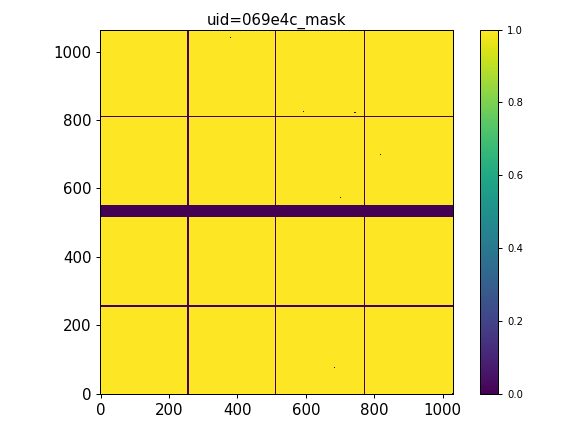

In [158]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = uidstr + '_mask', reverse= True ) 
mask =  mask * pixel_mask * Chip_Mask
show_img(mask,image_name = uidstr + '_mask', save=True, path=data_dir, aspect=1)
mask_load=mask.copy()
imgsa = apply_mask( imgs, mask )

In [159]:
#%run /home/yuzhang/chxanalys_link/chxanalys/chx_generic_functions.py

In [166]:
try:
    filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%md['uid']
    mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
         force_compress= force_compress,  para_compress= True,  bad_pixel_threshold = 1e14,
                        bins=1, num_sub= 100, num_max_para_process= 500, with_pickle=True  )
    img = avg_img
except:
    img = imgsa[0]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_069e4c12-7b38-46af-889b-dd0c772eb5f8.cmp.


<IPython.core.display.Javascript object>


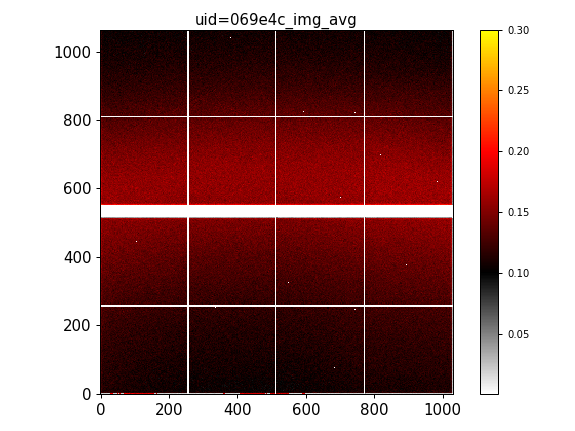

In [169]:
show_img( img ,  logs= False, vmin=0.001, vmax=0.3,  aspect=1, #save_format='tif',
         image_name= uidstr + '_img_avg',  save=True, path=data_dir,  cmap = cmap_albula,   )

In [170]:
%run /home/yuzhang/chxanalys_link/chxanalys/DataGonio.py

In [240]:
beam_x = int(inc_y0) #in pixel, x-cor in python plot  
beam_y = int(inc_x0) #1065 - 472 #in pixels, det shape in y - y-cor in python plot
print( beam_x, beam_y)

531 441


In [406]:
energy =  12.8  #keV
pixel_size_um= 75 # in mircro meters
wavelength_A =12.39842/energy
sam_det = 1.5 #in meters


#dq = 4*np.pi/wavelength_A  * (pixel_size_um/1e6/sam_det)

In [407]:
calibration = CalibrationGonio(wavelength_A= wavelength_A) # 20.0 keV
#calibration.set_image_size(1065 , height= 1030) # 1M, try, might be reverse
calibration.set_image_size(1030, height= 1065) # 1M, try, might be reverse
calibration.set_pixel_size(pixel_size_um=pixel_size_um)
calibration.set_beam_position(beam_x,  beam_y )
calibration.set_distance( sam_det )


In [421]:
gamma = 6.3 
delta = 0


In [422]:
4*np.pi*np.sin( np.radians( gamma/2) )/wavelength_A

0.71289014036873266

In [423]:
qint = np.array( [0.67, 0.83, 1.44] ) #interested Q vales

In [424]:
np.degrees( 2* np.arcsin( qint * wavelength_A/(4*np.pi) ) )

array([  5.92061993,   7.33624696,  12.74551689])

In [425]:
#img = imgsa[0]

In [426]:
calibration.set_angles(det_theta_g= gamma, det_phi_g= delta,   #diffractormeter first: two theta, second: delta
                sam_phi= 0, sam_theta= 0,  sam_chi=0,#sampe: first/sec/third, rotate along x/y/z                    
                      ) # det_phi_g is delta, det_theta_g is gamma at CHX

calibration._generate_qxyz_maps_samFrame()


# Get 1-D curve

In [427]:
qq, qqs, _ = convert_Qmap( img, qx_map=calibration.q_map_lab_data, 
                       qy_map=None, 
                       bins=[500], rangeq=None, mask=mask)

<IPython.core.display.Javascript object>


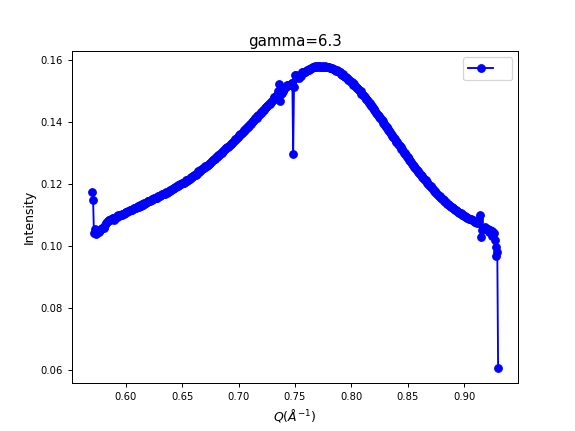

In [428]:
plot1D( qq, qqs, c='b', m='o', xlabel=r'$Q (\AA^{-1}$)', ylabel='Intensity', 
       title= 'gamma=%s'%gamma )

# Get Qmap Qr-Q

In [403]:
#calibration._generate_qxyz_maps()
qqr, qr0, qr1 = convert_Qmap( img, qx_map=calibration.q_map_lab_data, 
                       qy_map=calibration.qr_map_lab_data, 
                       bins=[500,500], rangeq=None, mask=mask)

<IPython.core.display.Javascript object>


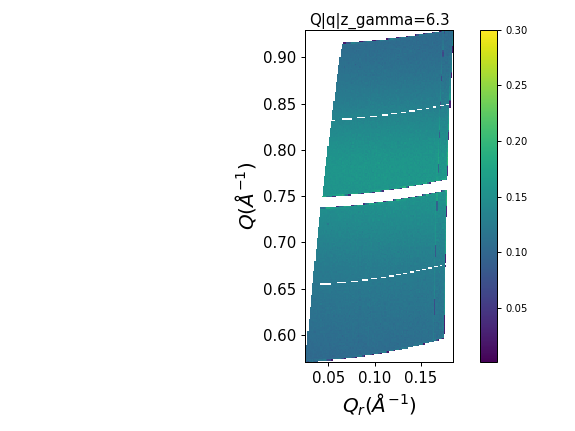

In [404]:

show_img( qqr, logs= False, vmin=0.001, vmax=.3, aspect=1, extent=[ qr1[0], qr1[-1],qr0[0], qr0[-1] ] ,
         
           xlabel=r'$Q_r (\AA^{-1}$)', ylabel=r'$Q (\AA^{-1}$)',
         image_name= 'Q|q|z_gamma=%s'%gamma )


<IPython.core.display.Javascript object>


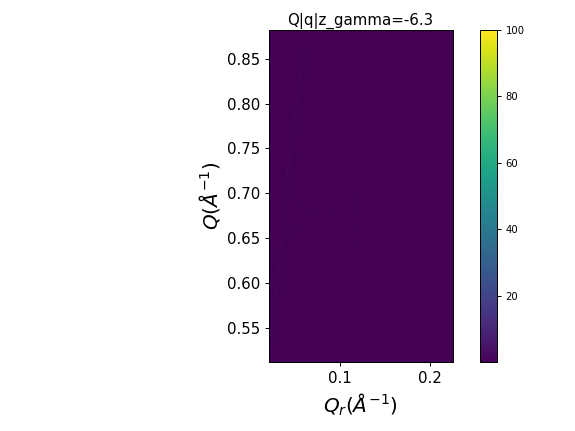

In [179]:

show_img( qqr, logs= False, vmin=0.1, vmax=1e2, aspect=1, extent=[ qr1[0], qr1[-1],qr0[0], qr0[-1] ] ,
         
           xlabel=r'$Q_r (\AA^{-1}$)', ylabel=r'$Q (\AA^{-1}$)',
         image_name= 'Q|q|z_gamma=%s'%gamma )
